# Project: Wrangling and Analyze Data

### Introduction

Real-world data rarely comes clean. Using Python and its libraries, I will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. 
The dataset to be wrangled (and analyzed and visualized) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

#### The Data

##### Enhanced Twitter Archive:
Udacity provided this data which contains basic tweet data for all 5000+ of the WeRateDogs tweets, but not everything. One column the archive does contain though: each tweet's text, which was used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced." Of the 5000+ tweets, Udacity has filtered for tweets with ratings only (there are 2356).

##### Additional Data via the Twitter API
retweet count and favorite count are two of the notable column omissions. Fortunately, this additional data can be gathered by anyone from Twitter's API. Well, "anyone" who has access to data for the 3000 most recent tweets, at least.I didn't get access to to developer account so I used a json file provided by Udacity for this project.

##### Image Predictions File
Udacity provided an image predictions file which is the end result of running every image in the WeRateDogs Twitter archive through a neural network that can classify breeds of dogs*. The results: a table full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images).

In [1]:
#importing necessary libraries 
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

## Data Gathering
In this section, the three data sets to be used for this project is gathered using various methods.

1. Directly downloading the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
#Loading the dataset 
twitter_archive=pd.read_csv("twitter-archive-enhanced.csv")

In [3]:

twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
908,757729163776290825,NaN,NaN,2016-07-26 00:08:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Chompsky. He lives up t...,6.790626e+17,4.196984e+09,2015-12-21 22:15:18 +0000,https://twitter.com/dog_rates/status/679062614...,11,10,Chompsky,None,None,None,None
1574,687480748861947905,NaN,NaN,2016-01-14 03:45:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Another magnificent photo. 12/10 https://t.co/...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/687480748...,12,10,None,None,None,None,None
639,793256262322548741,NaN,NaN,2016-11-01 01:00:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh h*ck look at this spookling right here. Fri...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/793256262...,12,10,None,None,None,None,None
164,860184849394610176,NaN,NaN,2017-05-04 17:30:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have perhaps the wisest dog of all. Ab...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/860184849...,14,10,None,None,None,None,None
1259,710272297844797440,NaN,NaN,2016-03-17 01:11:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We 👏🏻 only 👏🏻 rate 👏🏻 dogs. Pls stop sending i...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/710272297...,11,10,infuriating,None,None,None,None


2. Using the Requests library to download the tweet image prediction (image_predictions.tsv)

In [4]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=requests.get(url, auth=('user', 'pass'))

print(response.status_code)


200


In [5]:
open("image_predictions.tsv", "wb").write(response.content)

335079

In [6]:
image_predictions=pd.read_csv('image_predictions.tsv',sep='\t')
image_predictions.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1367,761745352076779520,https://pbs.twimg.com/media/CpJDWqhW8AAFt45.jpg,1,paddle,0.393118,False,canoe,0.178088,False,lakeside,0.099713,False
1822,834786237630337024,https://pbs.twimg.com/media/C5XBp19WYAA5a_v.jpg,1,Border_terrier,0.156276,True,Norwegian_elkhound,0.125912,True,Boston_bull,0.096624,True
1782,828770345708580865,https://pbs.twimg.com/media/C4BiOXOXAAAf6IS.jpg,1,seat_belt,0.765979,False,Chesapeake_Bay_retriever,0.033899,True,polecat,0.027252,False
1787,829501995190984704,https://pbs.twimg.com/media/C4L7p19W8AA3Fs_.jpg,1,French_bulldog,0.950851,True,Pekinese,0.015200,True,pug,0.011094,True
1908,852672615818899456,https://pbs.twimg.com/media/C9VNNp1XkAEWRFb.jpg,1,golden_retriever,0.711235,True,otterhound,0.068235,True,Sussex_spaniel,0.046562,True
890,699323444782047232,https://pbs.twimg.com/media/CbR-9edXIAEHJKi.jpg,1,Labrador_retriever,0.309696,True,doormat,0.303700,False,sliding_door,0.077266,False
1900,851464819735769094,https://pbs.twimg.com/media/C9ECujZXsAAPCSM.jpg,2,web_site,0.919649,False,menu,0.026306,False,crossword_puzzle,0.003482,False
819,692905862751522816,https://pbs.twimg.com/media/CZ2yNKhWEAA_7cb.jpg,1,Mexican_hairless,0.162638,True,Doberman,0.156287,True,Rhodesian_ridgeback,0.081478,True
54,667044094246576128,https://pbs.twimg.com/media/CUHREBXXAAE6A9b.jpg,1,golden_retriever,0.765266,True,Labrador_retriever,0.206694,True,seat_belt,0.010667,False
1086,718631497683582976,https://pbs.twimg.com/media/CfkXiX6W4AAmICF.jpg,1,Pomeranian,0.993718,True,Pekinese,0.003611,True,Persian_cat,0.000525,False


3. Using the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [ ]:
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = twitter_archive.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            #print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.errors.TweepyException as e:
            #print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

In [7]:
import json

tweets = []
for tweet in open('tweet-json.txt', 'r'):
    tweets.append(json.loads(tweet))

In [8]:
tweet_json = pd.DataFrame().from_dict(tweets).set_index('created_at')

In [9]:
tweet_json.sample(5)

,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
created_at,,,,,,,,,,,,,,,,,,,,,
Wed Oct 12 03:50:17 +0000 2016,786051337297522688,786051337297522688,13/10 for breakdancing puppo @shibbnbot,False,"[0, 39]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",7.727430e+17,772743019447607296,...,1614,False,False,NaN,NaN,en,NaN,NaN,NaN,NaN
Thu Jun 09 19:52:53 +0000 2016,740995100998766593,740995100998766593,This is Leo. He's a vape god. Blows o's for da...,False,"[0, 115]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 740995091762794496, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,7018,False,False,False,False,en,NaN,NaN,NaN,NaN
Sun Mar 05 01:36:26 +0000 2017,838201503651401729,838201503651401729,RT @dog_rates: Meet Sunny. He can take down a ...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,0,False,False,NaN,NaN,en,{'created_at': 'Sun Jan 15 21:49:15 +0000 2017...,NaN,NaN,NaN
Fri Jan 29 15:36:45 +0000 2016,693095443459342336,693095443459342336,This is Milo. He doesn't understand your fancy...,False,"[0, 134]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 693095429051932672, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,2056,False,False,False,False,en,NaN,NaN,NaN,NaN
Fri May 12 17:12:53 +0000 2017,863079547188785154,863079547188785154,Ladies and gentlemen... I found Pipsy. He may ...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 863079538779013120, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",6.671522e+17,667152164079423490,...,9094,False,False,False,False,en,NaN,NaN,NaN,NaN


## Assessing Data
In this section, the three loaded datasets will be assessed both visually and programmatically to detect quality and tidiness issues. 
At the end of this section, at least 8 data quality issues and two tidiness issues will be highlighted for cleaning.



In [10]:

twitter_archive.shape

(2356, 17)

In [11]:
image_predictions.shape

(2075, 12)

In [12]:
tweet_json.shape

(2354, 30)

In [13]:
#checking for duplicates
twitter_archive.duplicated().sum()

0

In [14]:
image_predictions.duplicated().sum()

0

In [15]:
#checking for data type and general info of data
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [17]:
tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2354 entries, Tue Aug 01 16:23:56 +0000 2017 to Sun Nov 15 22:32:08 +0000 2015
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             2354 non-null   int64  
 1   id_str                         2354 non-null   object 
 2   full_text                      2354 non-null   object 
 3   truncated                      2354 non-null   bool   
 4   display_text_range             2354 non-null   object 
 5   entities                       2354 non-null   object 
 6   extended_entities              2073 non-null   object 
 7   source                         2354 non-null   object 
 8   in_reply_to_status_id          78 non-null     float64
 9   in_reply_to_status_id_str      78 non-null     object 
 10  in_reply_to_user_id            78 non-null     float64
 11  in_reply_to_user_id_str        78 non-null     object 
 12

In [18]:
#checking for null values
(twitter_archive.isnull().sum()/len(twitter_archive))*100

tweet_id                       0.000000
in_reply_to_status_id         96.689304
in_reply_to_user_id           96.689304
timestamp                      0.000000
source                         0.000000
text                           0.000000
retweeted_status_id           92.317487
retweeted_status_user_id      92.317487
retweeted_status_timestamp    92.317487
expanded_urls                  2.504244
rating_numerator               0.000000
rating_denominator             0.000000
name                           0.000000
doggo                          0.000000
floofer                        0.000000
pupper                         0.000000
puppo                          0.000000
dtype: float64

In [19]:
(image_predictions.isnull().sum()/len(image_predictions))*100

tweet_id    0.0
jpg_url     0.0
img_num     0.0
p1          0.0
p1_conf     0.0
p1_dog      0.0
p2          0.0
p2_conf     0.0
p2_dog      0.0
p3          0.0
p3_conf     0.0
p3_dog      0.0
dtype: float64

In [20]:
(tweet_json.isnull().sum()/len(tweet_json))*100 

id                                 0.000000
id_str                             0.000000
full_text                          0.000000
truncated                          0.000000
display_text_range                 0.000000
entities                           0.000000
extended_entities                 11.937128
source                             0.000000
in_reply_to_status_id             96.686491
in_reply_to_status_id_str         96.686491
in_reply_to_user_id               96.686491
in_reply_to_user_id_str           96.686491
in_reply_to_screen_name           96.686491
user                               0.000000
geo                              100.000000
coordinates                      100.000000
place                             99.957519
contributors                     100.000000
is_quote_status                    0.000000
retweet_count                      0.000000
favorite_count                     0.000000
favorited                          0.000000
retweeted                       

In [21]:
#checking number of unique items per column
twitter_archive_cols=['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']
cols={}
for col in twitter_archive_cols:
    unique=twitter_archive[col].nunique()
    cols[col]=unique
    
cols

{'tweet_id': 2356,
 'in_reply_to_status_id': 77,
 'in_reply_to_user_id': 31,
 'timestamp': 2356,
 'source': 4,
 'text': 2356,
 'retweeted_status_id': 181,
 'retweeted_status_user_id': 25,
 'retweeted_status_timestamp': 181,
 'expanded_urls': 2218,
 'rating_numerator': 40,
 'rating_denominator': 18,
 'name': 957,
 'doggo': 2,
 'floofer': 2,
 'pupper': 2,
 'puppo': 2}

In [22]:
image_predictions_columns=['tweet_id','jpg_url',  'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

cols={}
for col in image_predictions_columns:
    unique=image_predictions[col].nunique()
    cols[col]=unique
    
cols

{'tweet_id': 2075,
 'jpg_url': 2009,
 'img_num': 4,
 'p1': 378,
 'p1_conf': 2006,
 'p1_dog': 2,
 'p2': 405,
 'p2_conf': 2004,
 'p2_dog': 2,
 'p3': 408,
 'p3_conf': 2006,
 'p3_dog': 2}

In [23]:
#programmatic assessment of the 'name' column
twitter_archive['name'].value_counts().head(20)

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Tucker      10
Penny       10
Lola        10
Winston      9
Bo           9
Sadie        8
the          8
Daisy        7
Buddy        7
Toby         7
an           7
Bailey       7
Leo          6
Oscar        6
Name: name, dtype: int64

In [24]:
#checking for consistency of rating_denominators
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
70        1
7         1
15        1
150       1
170       1
0         1
90        1
40        1
130       1
110       1
16        1
120       1
2         1
Name: rating_denominator, dtype: int64

In [25]:
#checking for retweets
twitter_archive[twitter_archive.retweeted_status_id.isnull()==False].shape[0]

181

In [26]:
#checking for tweet replies
twitter_archive[twitter_archive.in_reply_to_status_id.isnull()==False].shape[0]

78

In [27]:
tweet_json[tweet_json.in_reply_to_status_id.isnull()==False].shape[0]

78

In [28]:
tweet_json[tweet_json.quoted_status_id.isnull()==False].shape[0]

29

In [29]:
#checking for unneccessary predictions 
image_predictions.query('p1_dog==False and p2_dog==False and p3_dog==False').shape

(324, 12)

### Quality issues

Wrong Data Type(validity)
>1. Twitter archive table contains several columns such as 'timestamp' and 'tweet_id','in_reply_status_id','retweeted_status_id',etc with wrong data type.

>2. Image_prediction table 'tweet_id' column has a wrong data type.

>3. tweet_json table contains several columns such as 'retweet_count','tweet_id','in_reply_status_id','retweeted_status_id',etc with wrong data type.

Un-original tweets(consistency)
>4. Twitter_archive table contains tweets that are retweets, tweets that are quoted tweets and tweets that are reply to other tweets.

>5. Tweet_json table contains tweets that are retweets, tweets that are quoted tweets and tweets that are reply to other tweets.

Nulls(completeness)
>6. Too many redundant columns such as 'geo','coordinates',etc containing more than 90% null values

Accuracy
>7. 'name' column in the twitter_archive table contains 'a','an' and 'the' for dogs with no names

>8. innacurate rating_numerator and rating_denominator columns in the twitter_archive table


### Tidiness issues
1.retweet_count,favorite_count from tweet_json table and dog image predictions from image_predictions table should be part of the twitter_archive table

2.twitter_archive table contains categories of dogs by size split across three columns

3.Source device is part of the source column embedded in a link

## Cleaning Data
In this section,  **all** of the issues documented while assessing will be cleaned. 



In [30]:
# Make copies of original pieces of data
twitter_archiveCopy=twitter_archive.copy()
image_predictionsCopy=image_predictions.copy()
tweet_jsonCopy=tweet_json.copy()

A look at the quality issues shows how the three tables or dataset are similar in terms of issues with its data

To simplify cleaning in this project, the tidiness issues are tackled first as it contains merging the three tables together and then the quality issues are tackled one after the other by category.

### Tidiness

### Issue #1: retweet_count ,favorite_count , dog image predictions should be part of the twitter_archive table

#### Define: 
Merge the twitter_archive and tweet_json tables on tweet id as twitter_merged table,

Merge image_predictions table and twitter_merged table as twitter_archive_master

#### Code

In [31]:

tweet_jsonCopy.rename(columns={'id':'tweet_id'},inplace=True)

In [32]:
twitter_merged= twitter_archiveCopy.merge(tweet_jsonCopy, on=['tweet_id','in_reply_to_status_id','in_reply_to_user_id','source'],how='inner')
twitter_merged.shape

(2354, 43)

In [33]:
twitter_archive_master=twitter_merged.merge(image_predictionsCopy,how="inner",on="tweet_id")
twitter_archive_master.shape

(2073, 54)

#### Test

In [34]:
twitter_archive_master.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2023,666835007768551424,NaN,NaN,2015-11-18 04:27:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",These are Peruvian Feldspars. Their names are ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666835007...,...,1,Airedale,0.448459,True,toy_poodle,0.12403,True,teddy,0.110183,False


### Tidiness Issue #2: twitter_archive table contains categories of dogs by size split across three columns

#### Define
Extracting the dog stage from the text column and dropping 'doggo', 'floofer', 'pupper' and 'puppo' columns .

#### Code

In [35]:
#twitter_archive_master['stage']=None
twitter_archive_master['stage'] = twitter_archive_master.doggo + twitter_archive_master.floofer + twitter_archive_master.pupper + twitter_archive_master.puppo

In [36]:
twitter_archive_master.stage.value_counts()

NoneNoneNoneNone        1753
NoneNonepupperNone       210
doggoNoneNoneNone         67
NoneNoneNonepuppo         23
doggoNonepupperNone       11
NoneflooferNoneNone        7
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: stage, dtype: int64

In [37]:

stages=[]
for stage in twitter_archive_master.stage:
    clean_stage=stage.replace("None","")
    if len(clean_stage)>7:
        clean_stage="multiple"
    elif len(clean_stage)<1:
        clean_stage="None"
    stages.append(clean_stage)
    
twitter_archive_master['stage']=stages

In [38]:
twitter_archive_master.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'],inplace=True)

#### Test

In [39]:
twitter_archive_master.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage
1621,674743008475090944,NaN,NaN,2015-12-10 00:10:43 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She just saw a spider. 10/10 d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/674743008...,...,Bernese_mountain_dog,0.583054,True,Shetland_sheepdog,0.06599,True,Greater_Swiss_Mountain_dog,0.065236,True,None


### Tidiness Issue #3: Source device is part of the source column embedded in a link

#### Define
Extracting the source_device of tweet from the source column and renaming it as source_device using Beautiful Soup.

#### Code

In [40]:
from bs4 import BeautifulSoup 

source_device = []

for x,y in twitter_archive_master.iterrows():
    soup = BeautifulSoup(y.source)
    device = soup.find('a').contents[0]
    source_device.append(device)
    
twitter_archive_master['source_device']=source_device

#### Test

In [41]:
twitter_archive_master.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage,source_device
488,797545162159308800,NaN,NaN,2016-11-12 21:02:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She steals things. Guilt incre...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/797545162...,...,0.954089,True,Cardigan,0.033644,True,papillon,0.009736,True,None,Twitter for iPhone


### Quality

### Category #1: Wrong Data Type(Validity)

#### Define: 
Change the data type of columns with wrong data type

#### Code

In [42]:
for col in twitter_archive_master.columns:
    if "id" in col:
        twitter_archive_master[col]=twitter_archive_master[col].astype('object')
    elif "timestamp" in col:
        twitter_archive_master[col]=twitter_archive_master[col].astype('datetime64')
    elif "count" in col:
        twitter_archive_master[col]=twitter_archive_master[col].astype('int64')

#### Test

In [43]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2072
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   tweet_id                       2073 non-null   object        
 1   in_reply_to_status_id          23 non-null     object        
 2   in_reply_to_user_id            23 non-null     object        
 3   timestamp                      2073 non-null   datetime64[ns]
 4   source                         2073 non-null   object        
 5   text                           2073 non-null   object        
 6   retweeted_status_id            79 non-null     object        
 7   retweeted_status_user_id       79 non-null     object        
 8   retweeted_status_timestamp     79 non-null     datetime64[ns]
 9   expanded_urls                  2073 non-null   object        
 10  rating_numerator               2073 non-null   int64         
 11  rating_denominato

### Category #2: Unoriginal tweets(Consistency)

##### Removing retweets from dataset

#### Define
Finding the index of rows with 'retweeted_status_id' not null and removing such rows as they are not original tweets.

#### Code

In [44]:
def drop_unoriginal(column):
    unoriginal_index=twitter_archive_master[twitter_archive_master[column].isnull()==False].index
    twitter_archive_master.drop(unoriginal_index,axis=0,inplace=True)
    twitter_archive_master.drop(columns=[column],inplace=True)
    return twitter_archive_master.shape

#### Test

In [45]:
drop_unoriginal('retweeted_status_id')

(1994, 51)

##### Removing replies to tweets from dataset

#### Define
Finding the index of rows with 'in_reply_to_status_id' not null and removing such rows as they are not original tweets.

#### Test

In [46]:
drop_unoriginal('in_reply_to_status_id')

(1971, 50)

##### Removing quoted tweets from dataset

#### Define
Finding the index of rows with quoted_status_id' not null and removing such rows

### Test

In [47]:
drop_unoriginal('quoted_status_id')

(1971, 49)

In [48]:
twitter_archive_master.sample()

,tweet_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,stage,source_device
2025,666817836334096384,NaN,2015-11-18 03:18:55,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He is a German Boston Shuttlecoc...,NaN,NaT,https://twitter.com/dog_rates/status/666817836...,9,10,...,0.496953,True,standard_schnauzer,0.285276,True,giant_schnauzer,0.073764,True,None,Twitter for iPhone


### Category #3: Completeness: Too many redundant columns such as 'geo','coordinates',etc containing more than 90% null values

#### Define
Using a for loop to loop through all columns and remove columns with more than 90% null values

#### Code

In [49]:
columns=['tweet_id', 'in_reply_to_user_id', 'timestamp', 'source', 'text',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator', 'name',
       'id_str', 'full_text', 'truncated', 'display_text_range', 'entities',
       'extended_entities', 'in_reply_to_status_id_str',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'is_quote_status',
       'retweet_count', 'favorite_count', 'favorited', 'retweeted',
       'possibly_sensitive', 'possibly_sensitive_appealable', 'lang',
       'retweeted_status', 'quoted_status_id_str', 'quoted_status', 'jpg_url',
       'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'stage', 'source_device']

for col in columns:
    if twitter_archive_master[col].isnull().sum()!=0:
        twitter_archive_master.drop(columns=[col],inplace=True)

##### 'full_text' and 'text' columns are duplicates of each other so 'full_text' needs to be dropped and some other redundant columns

In [50]:
twitter_archive_master.drop(columns=['id_str', 'full_text',
       'truncated', 'display_text_range', 'entities', 'extended_entities', 'user', 'is_quote_status',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang'],inplace=True)

### Test

In [51]:
twitter_archive_master.shape

(1971, 23)

In [52]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2072
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1971 non-null   object        
 1   timestamp           1971 non-null   datetime64[ns]
 2   source              1971 non-null   object        
 3   text                1971 non-null   object        
 4   expanded_urls       1971 non-null   object        
 5   rating_numerator    1971 non-null   int64         
 6   rating_denominator  1971 non-null   int64         
 7   name                1971 non-null   object        
 8   retweet_count       1971 non-null   int64         
 9   favorite_count      1971 non-null   int64         
 10  jpg_url             1971 non-null   object        
 11  img_num             1971 non-null   int64         
 12  p1                  1971 non-null   object        
 13  p1_conf             1971 non-null   float64     

### Category #4: Accuracy

##### 'name' column in the twitter_archive table contains 'a','an' and 'the' for dogs with no names 

#### Define
Finding the index of rows with wrong names instead of None and changing the wrong names to None.

#### Code

In [53]:
wrong_namesIndex=twitter_archive_master[twitter_archive_master.name.str.islower()==True].index

In [54]:
twitter_archive_master.drop(wrong_namesIndex,axis=0,inplace=True)

#### Test

In [55]:
twitter_archive_master.shape

(1873, 23)

##### Innacurate rating_numerator and rating_denominator

#### Define
Extracting correct rating_numerator and rating_denominator from 'text'column

#### Code

In [56]:
response=[]
num=[]
den=[]
for text in twitter_archive_master.text:
    res = re.findall('[0-9]+', text)
    response.append(res)


for list in response:
    x=list[0]
    y=list[1]
    num.append(x)
    den.append(y)

twitter_archive_master['rating_numerator']=num
twitter_archive_master['rating_denominator']=den

twitter_archive_master.rating_denominator=twitter_archive_master.rating_denominator.astype('int64')
twitter_archive_master.rating_numerator=twitter_archive_master.rating_numerator.astype('int64')

#### Test

In [57]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873 entries, 0 to 2072
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1873 non-null   object        
 1   timestamp           1873 non-null   datetime64[ns]
 2   source              1873 non-null   object        
 3   text                1873 non-null   object        
 4   expanded_urls       1873 non-null   object        
 5   rating_numerator    1873 non-null   int64         
 6   rating_denominator  1873 non-null   int64         
 7   name                1873 non-null   object        
 8   retweet_count       1873 non-null   int64         
 9   favorite_count      1873 non-null   int64         
 10  jpg_url             1873 non-null   object        
 11  img_num             1873 non-null   int64         
 12  p1                  1873 non-null   object        
 13  p1_conf             1873 non-null   float64     

## Storing Data
In this section, the gathered, assessed, and cleaned master dataset will be saved into a CSV file named "twitter_archive_master.csv".

In [58]:
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False)

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [59]:
#splitting features into numerical and categorical
numeric_features=['rating_numerator', 'rating_denominator', 'retweet_count',
       'favorite_count', 'img_num', 'p1_conf', 
       'p2_conf', 'p3_conf']

categorical_features=['name','jpg_url', 'p1', 'p1_dog', 'p2',
        'p2_dog', 'p3', 'p3_dog', 'stage','source_device']

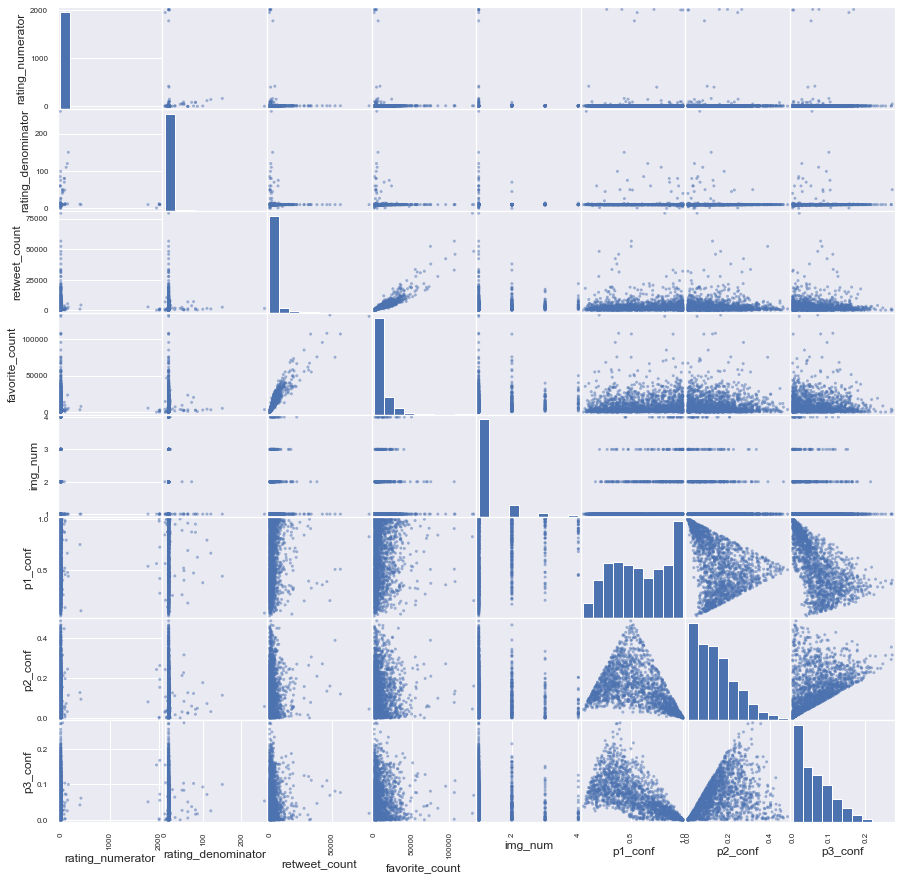

In [60]:
#scatter matrix of the numerical features
pd.plotting.scatter_matrix(twitter_archive_master[numeric_features],figsize=[15,15]);

### Insights:
1. The dog stage with the highest average retweet is different from the dog stage with the highest average likes but not by much!


2. Surprisingly, WeRateDogs twitter account mostly sent tweets from Iphones. You will be surprised at what they also tweet from!


3. WeRateDogs mostly tweeted after midnight!!


4. Not surprised! tweets with higher number of retweets tended to have more likes.


5. Standard poodle had the highest number of likes per picture. 

### Visualization

### Question 1: How do the different dog stages compare in terms of retweets and likes

In [61]:
twitter_sample=twitter_archive_master.query('stage!= "None"')

In [62]:
def box(y):
    plot=sns.boxplot(x='stage',y=y,data=twitter_sample)
    plt.title('Stages by {}'.format(y))
    #plt.savefig('box {}'.format(y))
    return plot

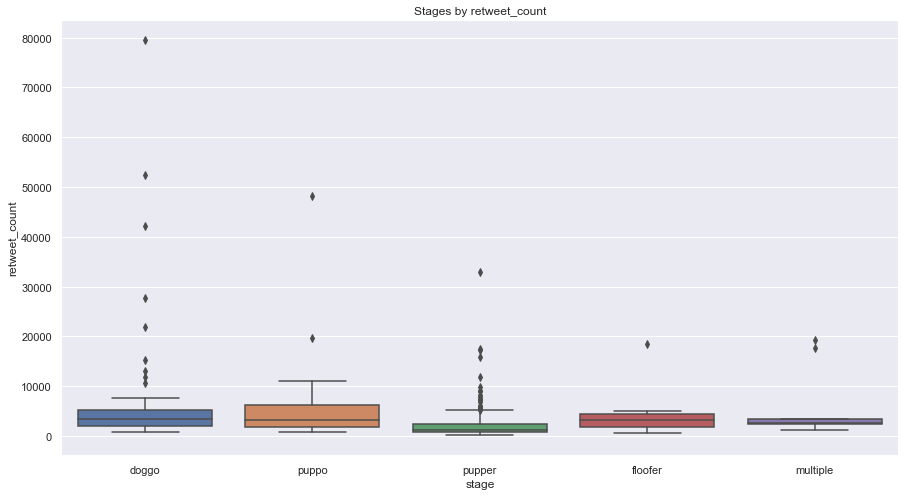

In [63]:
box('retweet_count');

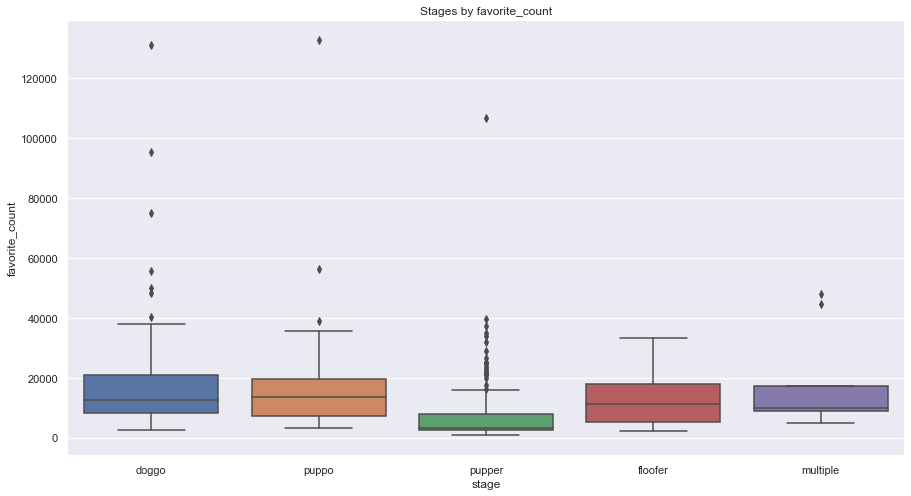

In [64]:
box("favorite_count");

In [65]:
def barplot(column):
    plot=twitter_sample.groupby('stage').mean()[column].sort_values().plot(kind='barh')
    plt.xlabel('Average {}'.format(column))
    plt.title('Average {} by stages'.format(column))
    #plt.savefig('bar {}'.format(column))
    return plot

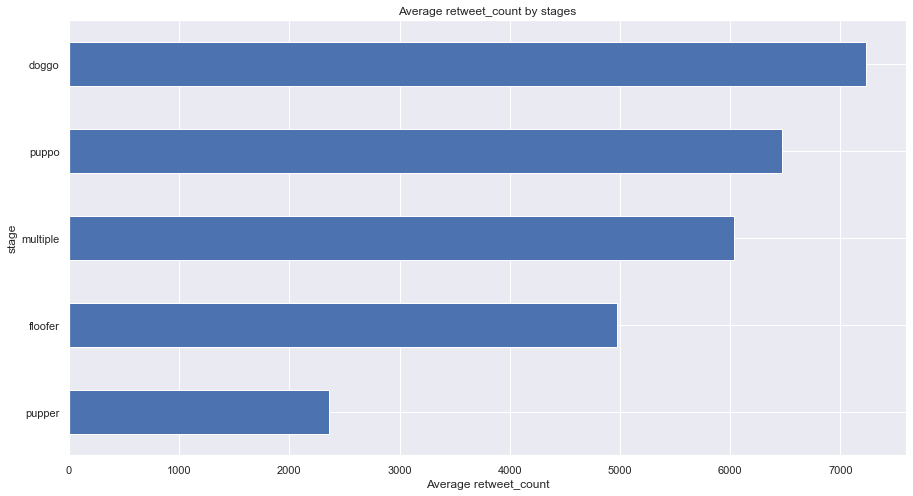

In [66]:
barplot('retweet_count');

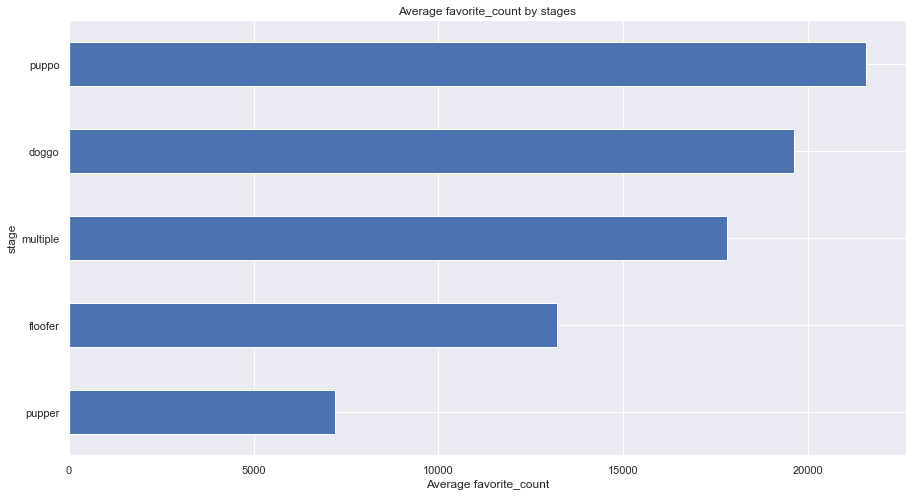

In [67]:
barplot('favorite_count');

##### Doggo had more average retweets than any other dog stage while puppo had the highest average likes than any other dog but notice how doggo came in second.

### Question 2: From what devices does the WeRateDogs account mostly tweet from?

<AxesSubplot:>

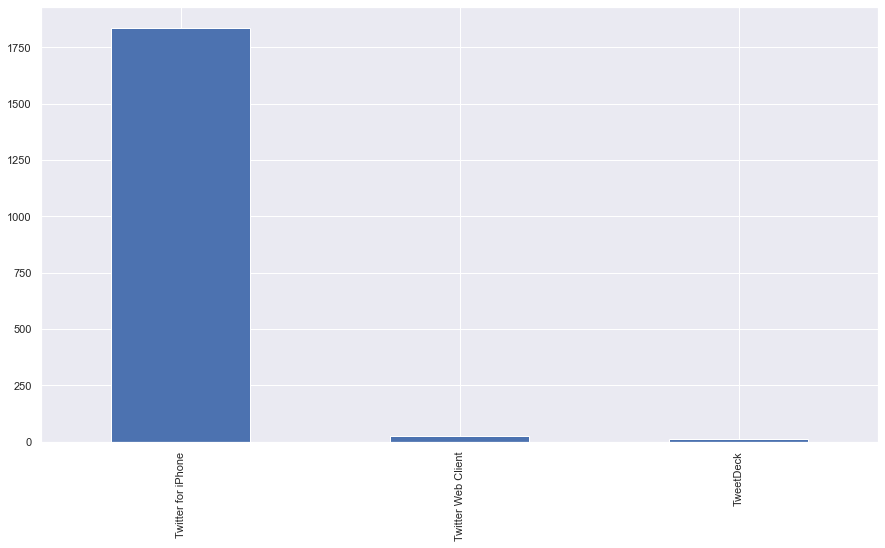

In [68]:
twitter_archive_master['source_device'].value_counts().plot(kind='bar')
#plt.savefig('source_device');

##### More than 80% of the tweets came from Iphones , followed by web client and finally deck! Iphones are known for their great picture quality!!!

### What time does the WeRateDogs twitter account mostly tweet?

In [69]:
twitter_copy=twitter_archive_master.copy()

In [70]:
for time in twitter_copy['timestamp']:
    t=time.time()
twitter_copy['timestamp'][0].time()

datetime.time(16, 23, 56)

In [71]:
twitter_copy['time']=twitter_copy['timestamp'].astype(str).str.split(" ",expand=True)[1]
twitter_copy['time']=twitter_copy['time'].astype(str).str.split(":",expand=True)[0]

Text(0, 0.5, 'Count of Tweets')

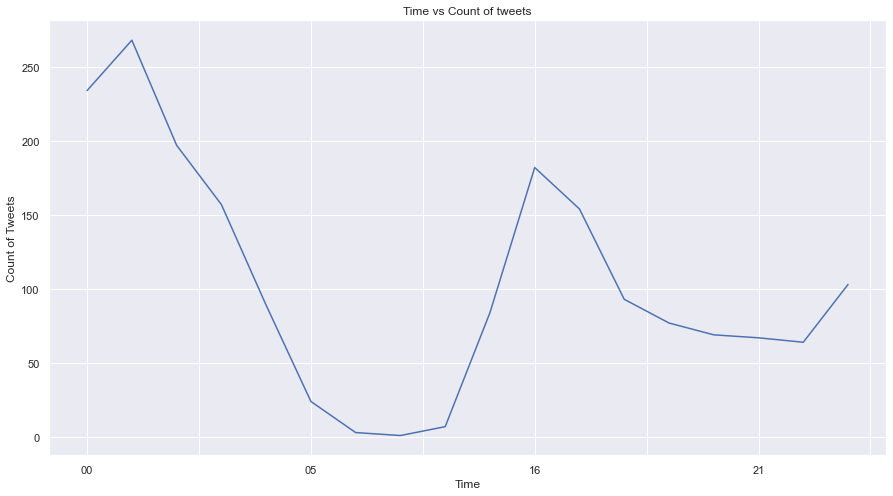

In [72]:
twitter_copy['time'].value_counts().sort_index().plot()
plt.title('Time vs Count of tweets')
plt.xlabel("Time")
plt.ylabel("Count of Tweets")
#plt.savefig('Time_count');


##### Most tweets came after midnight and ther is a sudden decline showing little or no tweet from 5am till the afternoon ... 

### Question 4: What characteristics are mostly associated with high likes?

In [73]:
mean_likes=twitter_archive_master['favorite_count'].mean()
mean_likes

9100.905499199145

In [74]:
#splitting the data into low and high likes 
twitter_high=twitter_archive_master.query('favorite_count >= 9100')
twitter_low=twitter_archive_master.query('favorite_count<9100')

In [75]:
def plot(col):
    plt.scatter(x=col,y="favorite_count",data=twitter_high, label='high likes')
    plt.scatter(x=col,y="favorite_count",data=twitter_low,label='low likes')
    correl=twitter_archive_master[col].corr(twitter_archive_master['favorite_count']).round(3)
    plt.title(f'Correlation between {col} and favorite_count is {correl}')
    plt.legend()
    #plt.savefig('plot {}'.format(col))

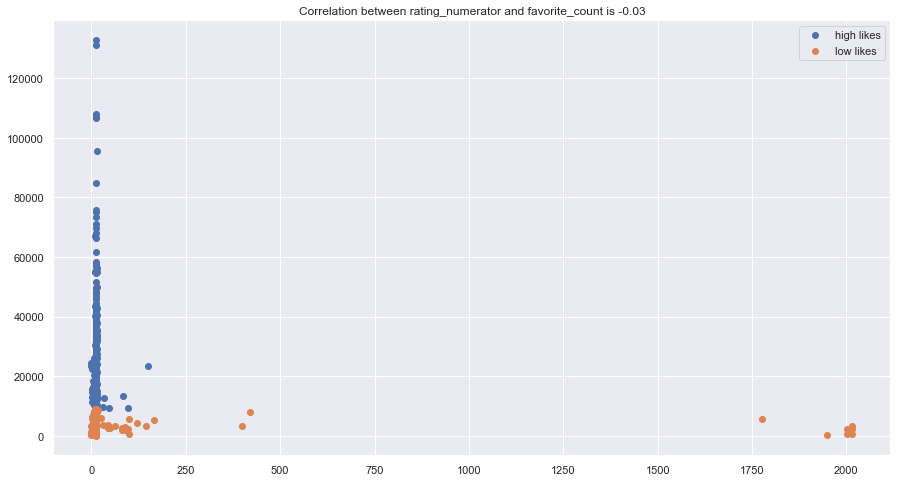

In [76]:
plot('rating_numerator')

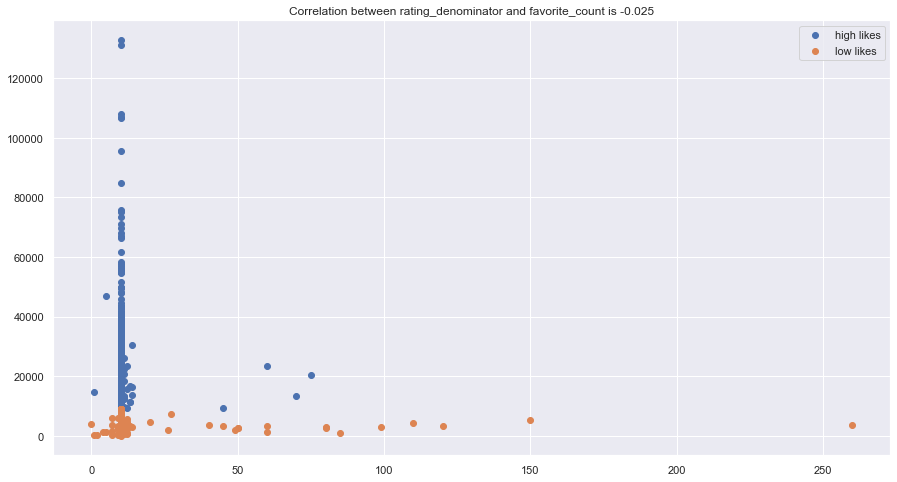

In [77]:
plot('rating_denominator')

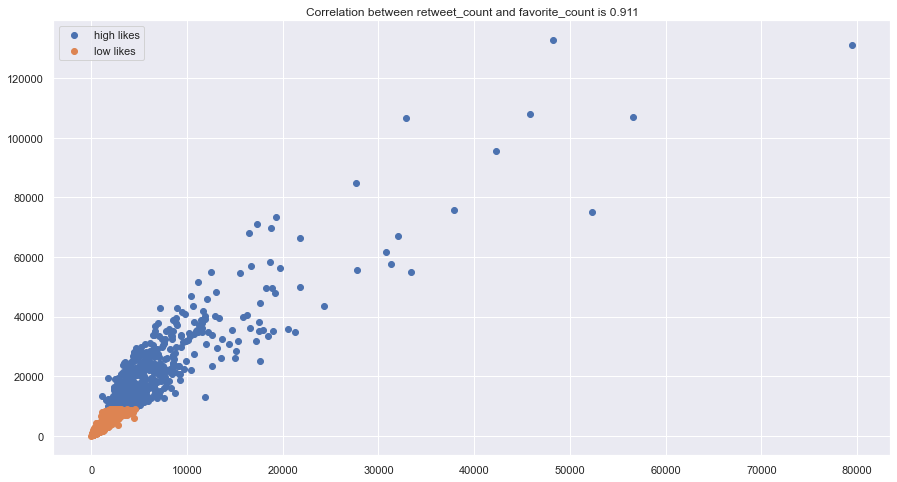

In [78]:
plot('retweet_count')

##### From the scatter plot of numerical features against likes, retweets had the highest correlation and showed more relationship than the others.

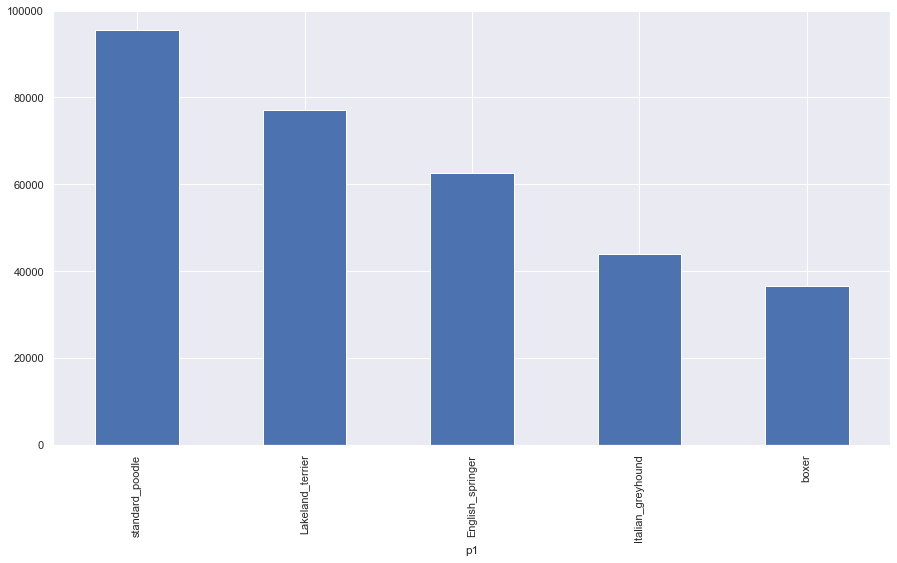

In [79]:
twitter_high.query('p1_dog==True').groupby('p1').mean()['favorite_count'].sort_values(ascending=False).head().plot(kind='bar');
#plt.savefig('breeds')

##### Of course standard_poodle!!! This breed is known for being a family dog and very cute! One thing to note is that most of them in the top 5 are good family dogs